<h1 align='center'> 1.3MM Tweets Sentimental Analysis <h1>

<h2 align='right'> Euiyoung (Jim) Chung <h2>


## Descriptions:


## Outline:

**I. Introduction ** <br>
a) Data Import<br>
b) Data Cleaning<br><br>

**II. Exploratory Data Analysis**<br>
a) Distributions<br>
b) Features vs. Target<br>
c) Among Features<br><br>

**III. Feature Engineering**<br>
a) Text Vectorization<br>
b) Feature Selection<br>
c) Categorization<br><br>

**IV. Modeling**<br>
a) Tying Multiple Models & Features<br>
b) What is Happening?<br>
c) Hyperparameter Tuning<br>
e) SMOTE - Oversampling<br><br>

**V. Evaluation**<br>
a) Confusion Matrix<br>
b) Error Analysis<br>
c) Insights from the Model



In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score, learning_curve,
                                    RandomizedSearchCV, cross_validate, validation_curve)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.feature_selection import chi2, SelectFromModel, SelectKBest
from sklearn.base import clone
from sklearn.preprocessing import Normalizer

import re, string

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
ls

testfile.com
training.1600000.processed.noemoticon.csv*
tweet_practice-Copy1.ipynb
tweet_practice.ipynb


<br>
# I. Introduction

## Data Import

** Findings **

- Messy text feature. This is the key information by which to classify the sentiment of the text
- It is expected that the time stamps and Ids also have information useful to my classification 


In [3]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None, encoding='latin-1')

In [4]:
df.head(3)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


In [6]:
df[0]

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
1599970    4
1599971    4
1599972    4
1599973    4
1599974    4
1599975    4
1599976    4
1599977    4
1599978    4
1599979    4
1599980    4
1599981    4
1599982    4
1599983    4
1599984    4
1599985    4
1599986    4
1599987    4
1599988    4
1599989    4
1599990    4
1599991    4
1599992    4
1599993    4
1599994    4
1599995    4
1599996    4
1599997    4
1599998    4
1599999    4
Name: 0, Length: 1600000, dtype: int64

In [173]:
# 2 int and 4 string features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
0    1600000 non-null int64
1    1600000 non-null int64
2    1600000 non-null object
3    1600000 non-null object
4    1600000 non-null object
5    1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [174]:
# There is no missing values detected FOR NOW
df.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

In [175]:
# Time stamps are valid
pd.to_datetime(df.iloc[:100,2]).head()

0   2009-04-06 22:19:45
1   2009-04-06 22:19:49
2   2009-04-06 22:19:53
3   2009-04-06 22:19:57
4   2009-04-06 22:19:57
Name: 2, dtype: datetime64[ns]

<br>
## Data Cleaning

In [176]:
#shuffle_ind = np.random.permutation(df.shape[0])
#df = df.iloc[shuffle_ind[:df.shape[0]//100]]
#df.reset_index(inplace=True, drop=True)

In [177]:
# Make it easy to handle the time
df[2] = pd.to_datetime(df[2])

# Time expansion
df['year'], df['month'], df['hour'] = df[2].dt.year, df[2].dt.month, df[2].dt.hour

# Categorize
df['is_daytime'] = df['hour'].between(8, 18).astype(int)

# This feature should be used carefully as some places have no seasons
season_map = dict(zip(range(1,13) ,['winter']*2 + ['spring']*3 + ['summer']*3 + ['winter']))
df['season'] = df['month'].map(season_map)

In [178]:
df.head()

,0,1,2,3,4,5,year,month,hour,is_daytime,season
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",2009,4,22,0,spring
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,2009,4,22,0,spring
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,2009,4,22,0,spring
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009,4,22,0,spring
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",2009,4,22,0,spring


In [179]:
# These columns are not infromative
print("all values of 3rd: ", df[3].unique())
print("almost all values of 1st are unique:", len(df[1].unique()))

all values of 3rd:  ['NO_QUERY']
almost all values of 1st are unique: 1598315


In [180]:
col_drops = [1, 3]
df = df.drop(col_drops, axis=1)

col_names = 'target,time,user_id,text,year,month,hour,is_daytime,season'.split(',')
df.columns = col_names

In [181]:
# Ready to analyze!
df.head()

,target,time,user_id,text,year,month,hour,is_daytime,season
0,0,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",2009,4,22,0,spring
1,0,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,2009,4,22,0,spring
2,0,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,2009,4,22,0,spring
3,0,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,2009,4,22,0,spring
4,0,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",2009,4,22,0,spring


In [182]:
labels = df['target']

<br>
<br>
# 2. Exploratory Data Analysis

## Distributions

- The proportion of the binary class is balanced.

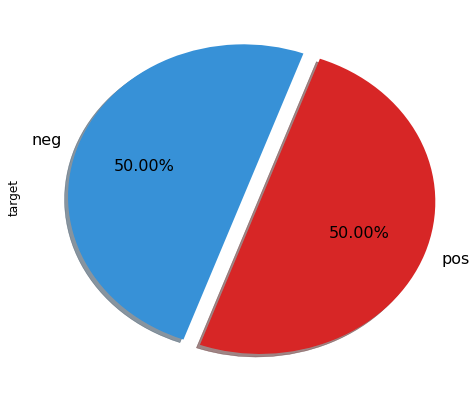

In [183]:
# We have a balanced target
colors = ["#3791D7", "#D72626"]
df["target"].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%', 
                                             shadow=True, colors=colors, 
                                             labels=["neg", "pos"], fontsize=16, startangle=70, figsize=(7,7))
plt.show()

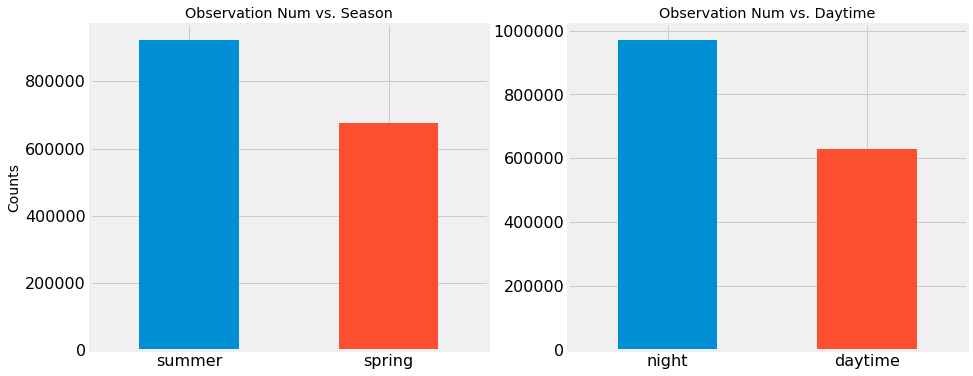

In [184]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

df['season'].value_counts().plot.bar(rot=0, fontsize=16, ax=ax1)

day_plot = df.groupby(['is_daytime']).size()
day_plot.index = ['night', 'daytime']
day_plot.plot.bar(rot=0, fontsize=16, ax=ax2)

ax1.set_title('Observation Num vs. Season')
ax1.set_ylabel('Counts', fontsize=14)
ax2.set_title('Observation Num vs. Daytime')

plt.show()

In [185]:
df['len'] = df['text'].str.len()

In [186]:
len_groupby = df.groupby(['len'])['target'].value_counts()/df.groupby(['len'])['target'].size()

len_groupby = len_groupby.unstack()
len_groupby.columns = ['Negative', 'Postivie']

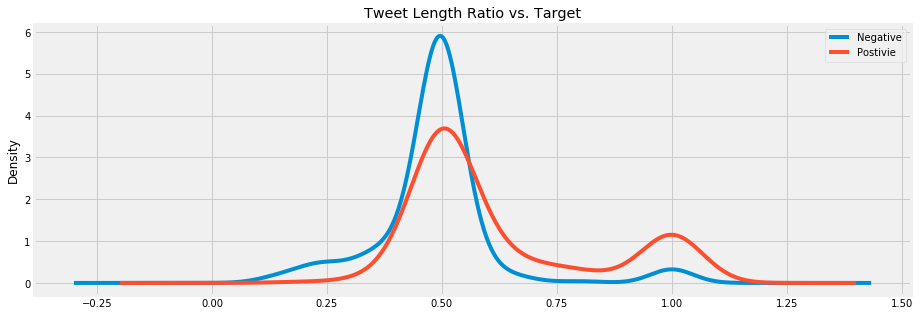

In [187]:
# Positive Tweets are slightly more verbose
len_groupby.plot.kde(figsize=(14,5), title="Tweet Length Ratio vs. Target")
plt.show()

<br>
<br>
# III. Feature Engineering

## Text Vectorization

### Approaches

### Summary

In [188]:
df.head()

,target,time,user_id,text,year,month,hour,is_daytime,season,len
0,0,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",2009,4,22,0,spring,115
1,0,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,2009,4,22,0,spring,111
2,0,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,2009,4,22,0,spring,89
3,0,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,2009,4,22,0,spring,47
4,0,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",2009,4,22,0,spring,111


In [189]:
pd.options.display.max_colwidth = 1000
df['text'].head(2)

0    @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
1        is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Name: text, dtype: object

In [190]:
# Tokenize
def preprocessing(titles):
    num_titles = titles.size
    
    clean_titles = []
    
    stops = set(stopwords.words("english"))
    
    for i in range(0, num_titles):
        letters_only = re.sub("[^a-zA-Z]", " ", titles[i]) 
        words = letters_only.lower().split()
        words = [w.lower() for w in words if not w in stops]  
        clean_titles.append(" ".join(words))
        
    return clean_titles

In [191]:
clean_text = preprocessing(df['text'])

In [192]:
# Tf-idf
def tf_idf(titles, ngram_range=(1,1), max_df=1.0, min_df=1, norm='l2'):

    tf_idf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, 
                                        max_df=max_df, min_df=min_df, norm=norm)
    vectors = tf_idf_vectorizer.fit_transform(titles)
    
    return vectors, tf_idf_vectorizer # This transformer will be used to vectorize test data again.

In [193]:
del tf_idf

# Tf-idf
def tf_idf(titles, ngram_range=(1,1), max_df=1.0, min_df=1, norm='l2'):

    tf_idf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, 
                                        max_df=max_df, min_df=min_df, norm=norm)
    vectors = tf_idf_vectorizer.fit_transform(titles)
    
    return vectors, tf_idf_vectorizer # This transformer will be used to vectorize test data again.

In [194]:
text_vec, tf_idf_vectorizer = tf_idf(clean_text, max_df=0.99, min_df=3)

In [195]:
# Feature Selection
def features_chi2(features, labels, n_features=5000):
    chi2_model = SelectKBest(chi2, k=n_features)
    new_features = chi2_model.fit_transform(features, labels)
    return new_features, chi2_model

def features_information_gain(features, labels, max_features=1000):
    tree_clf = tree.DecisionTreeClassifier(criterion="entropy", max_features=max_features)
    tree_clf = tree_clf.fit(features, labels)
    inf_gain = SelectFromModel(tree_clf, prefit=True)
    new_features = inf_gain.transform(features)
    return new_features, inf_gain
    
def features_lsa(features,n_components=100):
    svd = TruncatedSVD(n_components=n_components)
    normalizer =  Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    new_features = lsa.fit_transform(features)
    return new_features, lsa

In [196]:
chi2_vec, chi2_model = features_chi2(text_vec, labels, 100)
ig_vec, ig_model = features_information_gain(text_vec, labels, max_features=100)
lsa_vec, lsa_model = features_lsa(text_vec, 100)

<br>
<br>
# IV. Modeling

## Initial Model

In [90]:
from sklearn.model_selection import cross_validate

In [200]:
lr = LinearSVC()

test_val = cross_validate(lr, ig_vec, labels, scoring=['precision_weighted', 
                                                       'recall_weighted', 'f1_weighted'], cv=5)
    
precision = round(test_val['test_precision_weighted'].mean(), 3)
recall = round(test_val['test_recall_weighted'].mean(), 3)
fscore = round(test_val['test_f1_weighted'].mean(), 3)
    
print(vec_names[i], "Logistic", "- precision: {0}, recall: {1}, fscore: {2}".format(precision, recall, fscore))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs
LSA Logistic - precision: 0.772, recall: 0.77, fscore: 0.77


In [91]:
# Stratified Cross-validation
kfold = StratifiedKFold(n_splits=3, random_state=42)
lr = LogisticRegression()

# Evaluate
vec_names = ['Chi2', 'IG', "LSA"]
vec_type = []
clf_type = []
metrics = []

# Fit the model
for i, vec in enumerate([chi2_vec, ig_vec, lsa_vec]):
    test_val = cross_validate(lr, vec, labels, scoring=['precision_weighted', 
                                                       'recall_weighted', 'f1_weighted'], cv=10)
    
    precision = round(test_val['test_precision_weighted'].mean(), 3)
    recall = round(test_val['test_recall_weighted'].mean(), 3)
    fscore = round(test_val['test_f1_weighted'].mean(), 3)
    
    print(vec_names[i], "Logistic", "- precision: {0}, recall: {1}, fscore: {2}".format(precision, recall, fscore))
    
    vec_type.append(vec_names[i])
    clf_type.append("Logistic")
    metrics.append([precision, recall, fscore])

Chi2 Logistic - precision: 0.706, recall: 0.684, fscore: 0.675
IG Logistic - precision: 0.737, recall: 0.736, fscore: 0.736
LSA Logistic - precision: 0.692, recall: 0.691, fscore: 0.691


<br>
## Trying Multiple Models & Features

In [33]:
'''
shuffle_ind = np.random.permutation(df.shape[0])
short_vec = vec.iloc[shuffle_ind[:df.shape[0]//100]]
short_labels = labels.iloc[shuffle_ind[:df.shape[0]//100]]
'''

'\nshuffle_ind = np.random.permutation(df.shape[0])\nshort_vec = vec.iloc[shuffle_ind[:df.shape[0]//100]]\nshort_labels = labels.iloc[shuffle_ind[:df.shape[0]//100]]\n'

In [94]:
# Evaluation
def custom_cross_validate(text_matrix, labels, classifier="SVM", n_splits=10):
    clf = None
    precision = []
    recall = []
    fscore = []
    
    if classifier == "RF":
        clf = RandomForestClassifier()
    elif classifier == "NB":
        clf = MultinomialNB()
    elif classifier == "SVM":
        clf = LinearSVC()
    elif classifier == "XGB":
        clf = XGBClassifier()
    elif classifier == "KNN":
        clf = KNeighborsClassifier()
        
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(X=np.zeros(len(labels)), y=labels):
        clone_clf = clone(clf)
        X_train, X_test = text_matrix[train_index], text_matrix[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        clone_clf.fit(X_train, y_train)
        
        y_pred = clone_clf.predict(X_test)
        p,r,f,s = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        precision.append(p)
        recall.append(r)
        fscore.append(f)
        
    return round(np.mean(precision),3), round(np.mean(recall),3), round(np.mean(fscore),3)

In [96]:
for i, vec in enumerate([chi2_vec, ig_vec, lsa_vec]):
    for clf in ['SVM', 'RF', 'NB', 'KNN']:
        try:
            precision, recall, fscore = custom_cross_validate(vec, labels, clf, 10)
            
            vec_type.append(vec_names[i])
            clf_type.append(clf)
            metrics.append([precision, recall, fscore])
            
            print(vec_names[i], clf, "- precision: {0}, recall: {1}, fscore: {2}".format(precision, recall, fscore))
        except:
            pass

Chi2 SVM - precision: 0.71, recall: 0.685, fscore: 0.676
Chi2 RF - precision: 0.653, recall: 0.638, fscore: 0.628
Chi2 NB - precision: 0.689, recall: 0.658, fscore: 0.644
Chi2 KNN - precision: 0.676, recall: 0.653, fscore: 0.641
IG SVM - precision: 0.737, recall: 0.735, fscore: 0.735
IG RF - precision: 0.693, recall: 0.693, fscore: 0.693
IG NB - precision: 0.726, recall: 0.726, fscore: 0.726
IG KNN - precision: 0.661, recall: 0.652, fscore: 0.647
LSA SVM - precision: 0.692, recall: 0.692, fscore: 0.691
LSA RF - precision: 0.64, recall: 0.637, fscore: 0.635
LSA KNN - precision: 0.648, recall: 0.647, fscore: 0.647


<br>
# What is Happening?

In [97]:
def call_plot(xaxis, train_scores, test_scores, name_pred, name_param, scoring):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.rcParams['font.size'] = 12
    plt.figure(figsize=(10,4))
    plt.plot(xaxis, train_scores_mean, label='Train score')
    plt.plot(xaxis, test_scores_mean, label='Test score')
    plt.fill_between(xaxis, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.15)
    plt.fill_between(xaxis, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.15)
    plt.legend(fontsize=14)
    plt.xlabel(name_param)
    plt.ylabel(scoring)
    plt.title("{} {} vs. {}".format(name_pred, scoring, name_param))
    plt.show()

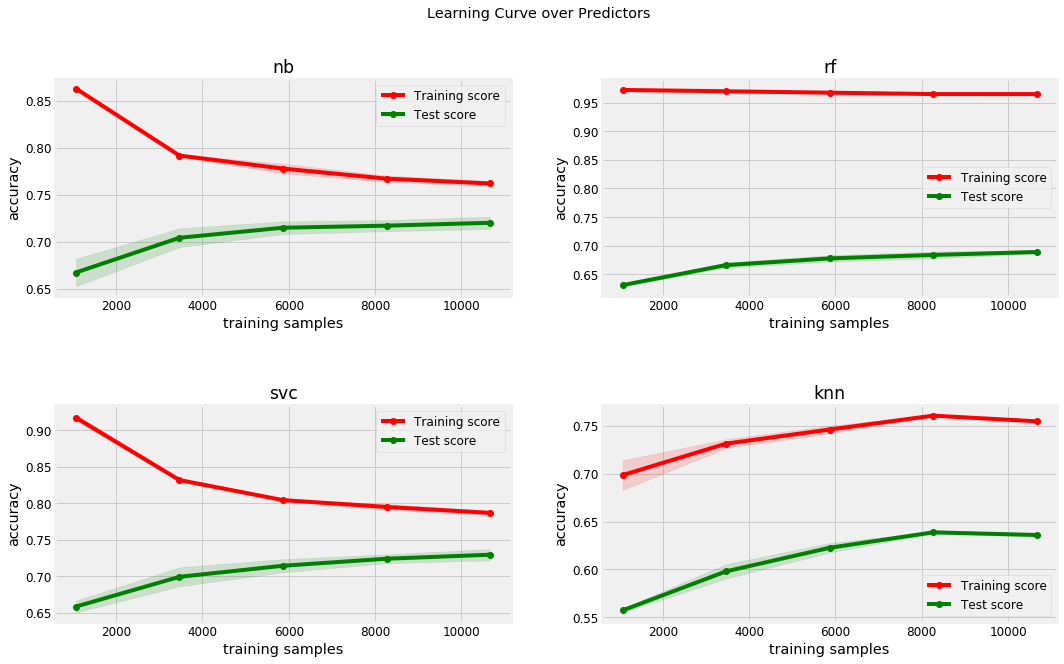

In [102]:
def plot_multiple_learning_curve(preds, X, y, title='', figsize=(13, 5), names=[], scoring='accuracy', cv=3):
    '''
    Calling learning curve plots for multiple predictors.
    Learning curves are good indicators of overfitting or underfitting.
    
    '''
    n_pred = len(preds)
    
    train_scores = {}
    test_scores = {}
    
    for i, pred in enumerate(preds):
        train_sizes, train_scores[names[i]], test_scores[names[i]] = learning_curve(pred, X, y, 
                                                                                    scoring=scoring, cv=cv)
    

    plt.rcParams['font.size'] = 12
    
    n_col = 2
    n_row = int(np.ceil(n_pred/2)) 
    does_last_exist = bool(n_pred%2) 
    
    fig, axs = plt.subplots(n_row, n_col, figsize=figsize, sharex=False, sharey=False)
    if does_last_exist:
        fig.delaxes(axs[n_row-1, 1])
    
    axs = axs.ravel()
    axs = axs[:-1] if does_last_exist else axs
    
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.5)
    
    for i, ax in enumerate(axs):
        mean_train_scores = np.mean(train_scores[names[i]], axis=1)
        mean_test_scores = np.mean(test_scores[names[i]], axis=1)
        std_train_scores = np.std(train_scores[names[i]], axis=1)
        std_test_scores = np.std(test_scores[names[i]], axis=1)
        
        ax.plot(train_sizes, mean_train_scores, 'o-', color='r',
                  label='Training score')
        ax.plot(train_sizes, mean_test_scores, 'o-', color='g',
                  label='Test score')
        ax.fill_between(train_sizes, mean_train_scores - std_train_scores,
                          mean_train_scores + std_train_scores, alpha=0.15, color='r')
        ax.fill_between(train_sizes, mean_test_scores - std_test_scores,
                          mean_test_scores + std_test_scores, alpha=0.15, color='g')
        ax.legend(loc='best')
        ax.set_xlabel('training samples')
        ax.set_ylabel(scoring)
        ax.set_title(names[i])
    

predictors = [MultinomialNB(), RandomForestClassifier(), LinearSVC(), KNeighborsClassifier()]
pred_names = ['nb', 'rf', 'svc', 'knn']

plot_multiple_learning_curve(predictors, ig_vec, labels, figsize=(16, 10), 
                              title='Learning Curve over Predictors', names=pred_names, scoring='accuracy', cv=3)

<br>
<br>
## Hyperparamter Tuning

In [201]:
# Linear SVC
param_grid = {'penalty': ['l1', 'l2'],
              'loss': ['hinge', 'squared_hinge'],
              'dual': [True, False],
              'C': [0.2, 0.4, 0.6, 0.8, 1.0],
              'multi_class': ['crammer_singer', 'ovr'],
              'class_weight': [None, 'balanced']}
              

clf = LinearSVC()
svc_rs = RandomizedSearchCV(clf, param_grid, n_iter=10, n_jobs=-1, cv=3, 
                        scoring='f1_weighted', error_score=0)
svc_rs.fit(ig_vec, labels)

best_svc = svc_rs.best_estimator_

test_val = cross_validate(best_svc, ig_vec, labels, scoring=['precision_weighted', 
                                                       'recall_weighted', 'f1_weighted'], cv=10)

precision = test_val['test_precision_weighted'].mean()
recall = test_val['test_recall_weighted'].mean()
fscore = test_val['test_f1_weighted'].mean()
    
print("ig vector -", "SVC", "- precision: {0}, recall: {1}, fscore: {2}".format(precision, recall, fscore))

ig vector - SVC - precision: 0.7739973029555995, recall: 0.7725574999999999, fscore: 0.7722579666091455


In [202]:
best_svc.get_params

<bound method BaseEstimator.get_params of LinearSVC(C=0.2, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)>

In [ ]:
# Random Forest
rf_param_grid = {
    'n_estimators': np.linspace(10, 100).astype(int),
    'max_depth': [None] + list(np.linspace(5, 30).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier()
rf_rs = RandomizedSearchCV(rf, rf_param_grid, n_jobs = -1, 
                        scoring = 'f1_weighted', cv = 3, 
                        n_iter = 10, verbose = 1)
rf_rs.fit(ig_vec, labels)


best_rf = svc_rs.best_estimator_

test_val = cross_validate(best_rf, ig_vec, labels, scoring=['precision_weighted', 
                                                       'recall_weighted', 'f1_weighted'], cv=10)

precision = test_val['test_precision_weighted'].mean()
recall = test_val['test_recall_weighted'].mean()
fscore = test_val['test_f1_weighted'].mean()
    
print('ig vector -', "Random Forest", "- precision: {0}, recall: {1}, fscore: {2}".format(precision, recall, fscore))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


## Again, What is happening?

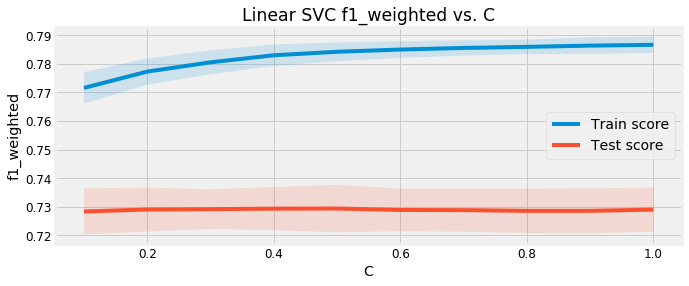

In [120]:
# Validation Curve
def plot_val_curve(predictor, X, y, name_param, name_pred, param_space, scoring='accuracy', cv=3):
    train_scores, test_scores = validation_curve(predictor, X, y, name_param,
                                               param_space, scoring=scoring, cv=cv)
    call_plot(param_space, train_scores, test_scores, name_pred, name_param, scoring)
    
plot_val_curve(LinearSVC(), ig_vec, labels, 'C',
               'Linear SVC', [d/10 for d in range(1,11)], scoring='f1_weighted')

<br>
# This is not the end - SMOTE

In [134]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, ratio = 1.0)
exteneded_ig_vec, extended_labels = sm.fit_sample(ig_vec, labels)

In [135]:
test_val = cross_validate(best_svc, exteneded_ig_vec, extended_labels, scoring=['precision_weighted', 
                                                       'recall_weighted', 'f1_weighted'], cv=10)

precision = test_val['test_precision_weighted'].mean()
recall = test_val['test_recall_weighted'].mean()
fscore = test_val['test_f1_weighted'].mean()
    
print("ig vector -", "SVC", "- precision: {0}, recall: {1}, fscore: {2}".format(precision, recall, fscore))

ig vector - SVC - precision: 0.7366290451535574, recall: 0.7351873904502165, fscore: 0.734775960779601


### Further recall & precision analysis was omitted due to the time limitation! Still, the logic is clear.

<br>
<br>
# V. Evaluation

## Confusion Matrix

In [144]:
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

Accuracy : 0.77225
Classification Report
             precision    recall  f1-score   support

          0     0.7923    0.7391    0.7648      8015
          4     0.7547    0.8055    0.7793      7985

avg / total     0.7735    0.7722    0.7720     16000



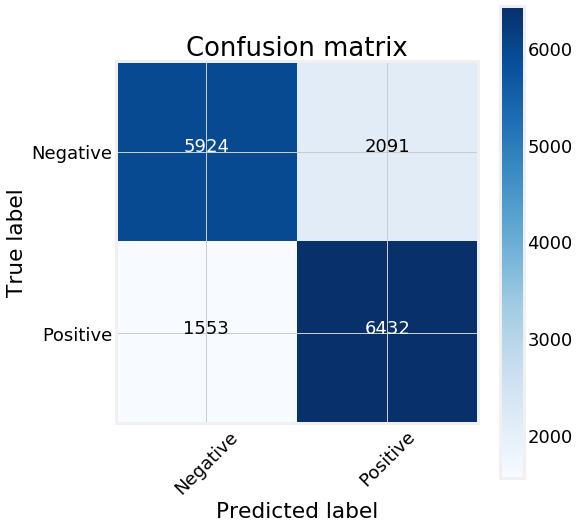

In [145]:
# Full-Report
def plot_confusion_mat(cm, classes, cmap=plt.cm.Blues):
    title='Confusion matrix'
    
    plt.rcParams['font.size'] = 18
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def full_report(model, x, y_true, classes):
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict(x)
    y_true = y_true

    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true, y_pred)))
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true, y_pred, digits=4))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    #print(cnf_matrix)
    plot_confusion_mat(cnf_matrix, classes=classes)  

full_report(best_svc, ig_vec, labels, ['Negative', 'Positive'])

<br>
## Error Analysis

Text(0.5,0,'Predicted label')

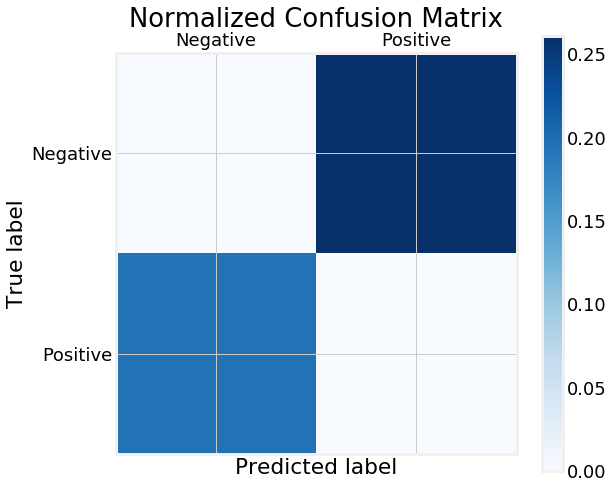

In [168]:
# Confusion Matrix - test
y_pred = best_svc.predict(ig_vec)
conf_mx = confusion_matrix(labels, y_pred)

def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)

# Closer look on errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrix(norm_conf_mx)

classes = ['Negative', 'Positive']


plt.title('Normalized Confusion Matrix')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')